# Interest Rate Prediction

## Case Study

This data belongs to a loan aggregator agency which connects loan applications to different financial institutions in attempt to get the best interest rate. They want to now utilise past data to predict interest rate given by any financial institute just by looking at loan application characteristics.

To achieve that , they have decided to do a POC with a data from a particular financial institution. The data is given in the file "loans data.csv". Lets begin: 

## Step 0: Basic Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Load dataset

In [2]:
train_file='data/loan_data_train.csv' #relative path. So in present working directory it will look for data folder.
test_file='data/loan_data_test.csv'

df_train=pd.read_csv(train_file) #read_csv is a function in pandas.
df_test=pd.read_csv(test_file)               

In [3]:
print(df_train.shape) #check no of rows (ie the no of data points) and cols (ie the no of features)
df_train.head() #display the first 5 columns in your dataset

(2200, 15)


,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,79542.0,25000,25000,18.49%,60 months,debt_consolidation,27.56%,VA,MORTGAGE,8606.56,720-724,11,15210,3.0,5 years
1,75473.0,19750,19750,17.27%,60 months,debt_consolidation,13.39%,NY,MORTGAGE,6737.50,710-714,14,19070,3.0,4 years
2,67265.0,2100,2100,14.33%,36 months,major_purchase,3.50%,LA,OWN,1000.00,690-694,13,893,1.0,< 1 year
3,80167.0,28000,28000,16.29%,36 months,credit_card,19.62%,NV,MORTGAGE,7083.33,710-714,12,38194,1.0,10+ years
4,17240.0,24250,17431.82,12.23%,60 months,credit_card,23.79%,OH,MORTGAGE,5833.33,730-734,6,31061,2.0,10+ years


14 features and 1 target variable

In [4]:
#test data does not have interest rate
print(df_test.shape)
df_test.sample(5)

(300, 14)


,ID,Amount.Requested,Amount.Funded.By.Investors,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
180,53234,7150,7150,36 months,debt_consolidation,12.33%,IL,RENT,3666.67,685-689,11,10561,1,< 1 year
61,45728,35000,34900,60 months,debt_consolidation,20.56%,GA,MORTGAGE,5666.67,725-729,8,22290,0,10+ years
199,1977,7500,6025,36 months,debt_consolidation,17.50%,CA,OWN,5000.00,675-679,11,16422,0,< 1 year
278,6363,24250,24175,36 months,debt_consolidation,21.90%,NY,OWN,5000.00,740-744,15,100842,1,< 1 year
71,44547,20000,19975,36 months,debt_consolidation,6.81%,NY,RENT,5500.00,660-664,11,9028,1,3 years


## Step 2: Data Visualisation and Feature Selection

### 2.1. Check dtypes

In [5]:
#df_train.dtypes #this will return a list of the columns and their respective dtypes
df_train.dtypes.unique() #will give the unique dtypes in my dataset

array([dtype('float64'), dtype('O')], dtype=object)

In [6]:
#df_train.select_dtypes("object") --> this will return a dataframe with only object type columns
obj_cols = df_train.select_dtypes("object").columns
obj_cols, len(obj_cols)

(Index(['Amount.Requested', 'Amount.Funded.By.Investors', 'Interest.Rate',
        'Loan.Length', 'Loan.Purpose', 'Debt.To.Income.Ratio', 'State',
        'Home.Ownership', 'FICO.Range', 'Open.CREDIT.Lines',
        'Revolving.CREDIT.Balance', 'Employment.Length'],
       dtype='object'), 12)

Dtypes for 12 feature has to be fixed

In [7]:
print(df_train[obj_cols].shape)
df_train[obj_cols].sample(5) #slicing of dataframe-->dataframe[list_of_desired_cols]

(2200, 12)


,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Employment.Length
1797,12000,11650,13.23%,60 months,car,20.76%,FL,MORTGAGE,730-734,15,21583,3 years
411,12000,11975,12.12%,36 months,major_purchase,31.34%,NY,OWN,710-714,21,28703,3 years
1092,5000,5000,12.61%,36 months,debt_consolidation,13.40%,CA,RENT,695-699,9,1753,2 years
1613,12000,11998.2,10.37%,36 months,debt_consolidation,16.98%,CT,RENT,705-709,10,7489,3 years
1976,6000,6000,16.29%,36 months,credit_card,20.96%,TX,MORTGAGE,665-669,10,7335,4 years


In [8]:
df_train["Loan.Length"].value_counts() #unique value and the count of each value

36 months    1722
60 months     476
.               1
Name: Loan.Length, dtype: int64

In [9]:
df_train["Loan.Purpose"].value_counts()

debt_consolidation    1147
credit_card            394
other                  174
home_improvement       135
major_purchase          84
small_business          80
car                     45
wedding                 35
medical                 26
moving                  25
house                   19
vacation                18
educational             14
renewable_energy         3
Name: Loan.Purpose, dtype: int64

In [10]:
df_train["Home.Ownership"].value_counts()

MORTGAGE    1018
RENT         999
OWN          177
OTHER          4
NONE           1
Name: Home.Ownership, dtype: int64

### 2.1.1. Some observations

1. 'Amount.Requested': **convert it to numeric**
2. 'Amount.Funded.By.Investors': **drop**
3. 'Interest.Rate': **remove % and then to numeric**
4. 'Loan.Length': **dummies for categories**
5. 'Loan.Purpose': **dummies for categories**
6. 'Debt.To.Income.Ratio': **remove % and then to numeric**
7. 'State': **dummies for categories**
8. 'Home.Ownership': **dummies for categories**
9. 'FICO.Range': **replace it by a numeric column which is average of the range**
10. 'Open.CREDIT.Lines': **convert it to numeric**
11. 'Revolving.CREDIT.Balance': **convert it to numeric**
12. 'Employment.Length': **convert it to number**


##### Lets group by operation:

1. drop: 
    - ID 
    - Amount.Funded.By.Investors
<br>
2. convert it to numeric 
    - Amount.Requested
    - Open.CREDIT.Lines
    - Revolving.CREDIT.Balance
<br>
3. remove % and then to numeric
    - Interest Rate
    - Debt to income ratio
<br>
4. replace it by a numeric column which is average of the range
    - FICO.Range 
<br>
5. convert to number:
    - Employment Length 
<br>
6. dummies for categories with good occurence rate:
    - Loan Lenth
    - Loan Purpose
    - State
    - Home ownership

### 2.1.2. Fix Dtypes

#### Operation 1: df.drop([ ], inplace=True)

In [11]:
df_train.shape

(2200, 15)

In [12]:
df_train.drop(['ID','Amount.Funded.By.Investors'], axis=1, inplace=True) #with inplace=True df_train will itself change. 

In [13]:
df_train.shape

(2200, 13)

#### Operation 2: pd.to_numeric

We can see that many columns which should have really been numbers have been imported as character columns , probably because some characters values in those columns in the files. We'll convert all such columns to numbers .

In [14]:
df_train.dtypes

Amount.Requested                   object
Interest.Rate                      object
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio               object
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                  object
Revolving.CREDIT.Balance           object
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

In [15]:
for col in ['Amount.Requested', 'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
    df_train[col]=pd.to_numeric(df_train[col], errors='coerce') 

In [16]:
df_train.dtypes

Amount.Requested                  float64
Interest.Rate                      object
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio               object
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

#### Operation 3: First String operation df[col].str.string_operation --> pd.to_numeric

variable `Interest.Rate` and `Debt.To.Income.Ratio` contain "%" sign in their values and because of which they have come as character columns in the data. Lets remove these percentages first.

In [ ]:
#"aa%bb".replace("%","") #"aabb"

In [17]:
df_train['Interest.Rate'].sample(2)

865     7.29%
858    17.77%
Name: Interest.Rate, dtype: object

In [18]:
for col in ['Interest.Rate','Debt.To.Income.Ratio']:
    print(col)
    df_train[col]=df_train[col].str.replace("%","") #first convert the row value to string type
                                                    #and then perfrom replace operation

Interest.Rate
Debt.To.Income.Ratio


In [19]:
#Lets check the effect of replace operation
df_train['Interest.Rate'].sample(2)

1570    6.62
847     7.90
Name: Interest.Rate, dtype: object

In [20]:
#Now we can convert to numeric
for col in ['Interest.Rate','Debt.To.Income.Ratio']:
    df_train[col]=pd.to_numeric(df_train[col],errors='coerce') 

In [21]:
df_train.dtypes

Amount.Requested                  float64
Interest.Rate                     float64
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio              float64
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

#### Operation 4: .str.split(expand=True) -->df_train[new_name]

If we look at first few values of variable FICO.Range , we can see that we can convert it to numeric by taking average of the range given. To do that first we need to split the column with "-", so that we can have both end of ranges in separate columns and then we can simply average them.

In [22]:
"660-770".split("-") #for understanding

['660', '770']

In [23]:
df_train['FICO.Range'].sample(2)

876    705-709
637    685-689
Name: FICO.Range, dtype: object

In [24]:
k=df_train['FICO.Range'].str.split("-", expand=True).astype(float)

In [25]:
#now k is a new dataframe with two columns and same no of rows
k.head()

,0,1
0,720.0,724.0
1,710.0,714.0
2,690.0,694.0
3,710.0,714.0
4,730.0,734.0


In [26]:
#creating a new column "fico" with average from k[0] (ie lower range) and k[1] (ie upper range)
df_train['fico']=0.5*(k[0]+k[1])
del df_train['FICO.Range']

In [27]:
df_train.dtypes

Amount.Requested                  float64
Interest.Rate                     float64
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio              float64
State                              object
Home.Ownership                     object
Monthly.Income                    float64
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
fico                              float64
dtype: object

#### Operation 5: np.where(condition, value_if_True, value_if_False)

In [28]:
#checking unique values for "Employment.Length" and their corresponding values
df_train['Employment.Length'].value_counts()

10+ years    575
< 1 year     229
2 years      217
3 years      203
5 years      181
4 years      162
1 year       159
6 years      134
7 years      109
8 years       95
9 years       66
.              1
Name: Employment.Length, dtype: int64

In [29]:
df_train['Employment.Length']=df_train['Employment.Length'].str.replace('years',"")
df_train['Employment.Length']=df_train['Employment.Length'].str.replace('year',"")

In [30]:
#verifying the two replace operations we performed
df_train['Employment.Length'].value_counts()

10+     575
< 1     229
2       217
3       203
5       181
4       162
1       159
6       134
7       109
8        95
9        66
.         1
Name: Employment.Length, dtype: int64

In [31]:
"78+00"[:2] #take index 0 and index 1. 

'78'

In [33]:
#np.where(condition, value_if_True, value_if_False)
df_train['Employment.Length'] = np.where(df_train['Employment.Length'].str[:2]=="10",10,
                                         df_train['Employment.Length'])

df_train['Employment.Length']=np.where(df_train['Employment.Length'].str[0]=="<",0,
                                       df_train['Employment.Length'])

In [34]:
df_train['Employment.Length'].value_counts()

10    575
0     229
2     217
3     203
5     181
4     162
1     159
6     134
7     109
8      95
9      66
.       1
Name: Employment.Length, dtype: int64

In [35]:
df_train['Employment.Length']=pd.to_numeric(df_train['Employment.Length'],errors='coerce')

In [36]:
df_train['Employment.Length'].value_counts()

10.0    575
0.0     229
2.0     217
3.0     203
5.0     181
4.0     162
1.0     159
6.0     134
7.0     109
8.0      95
9.0      66
Name: Employment.Length, dtype: int64

In [37]:
df_train.dtypes

Amount.Requested                  float64
Interest.Rate                     float64
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio              float64
State                              object
Home.Ownership                     object
Monthly.Income                    float64
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                 float64
fico                              float64
dtype: object

#### Operation 6: One hot encoding

In [38]:
# Notice that to apply string function on pandas data frame columns you need to str attribute
cat_cols=df_train.select_dtypes(['object']).columns
cat_cols

Index(['Loan.Length', 'Loan.Purpose', 'State', 'Home.Ownership'], dtype='object')

In [40]:
print("*"*50)
for col in cat_cols:
    print(col)
    print("-"*50)
    print(df_train[col].nunique())
    print("-"*50)
    print(df_train[col].value_counts())
    print("*"*50)

**************************************************
Loan.Length
--------------------------------------------------
3
--------------------------------------------------
36 months    1722
60 months     476
.               1
Name: Loan.Length, dtype: int64
**************************************************
Loan.Purpose
--------------------------------------------------
14
--------------------------------------------------
debt_consolidation    1147
credit_card            394
other                  174
home_improvement       135
major_purchase          84
small_business          80
car                     45
wedding                 35
medical                 26
moving                  25
house                   19
vacation                18
educational             14
renewable_energy         3
Name: Loan.Purpose, dtype: int64
**************************************************
State
--------------------------------------------------
46
--------------------------------------------------
CA   

In [58]:
# you can use following method if you want to ignore categories with too low frequencies ,
# in next section for logistic regression we will be using  pandas' get dummies function. 
# you can work with either of these . 
# ignoring categories with low frequencies however will result in fewer columns without 
# affecting model performance too much .
to_store = []
new_cols = []

for col in cat_cols:
    
    freqs = df_train[col].value_counts()
    categories = freqs.index[freqs>20]
    to_store.append((col, categories))
    
    for category in categories:
        name=col+'.'+category
        new_cols.append(name)
        df_train[name]=(df_train[col]==category).astype(int)
    del df_train[col]
    print(col)

Loan.Length
Loan.Purpose
State
Home.Ownership


In [62]:
df_train.shape

(2200, 50)

In [65]:
new_cols #we are storing all categorical feature names so that extracting numerical feature name is easy. 

['Loan.Length.36 months',
 'Loan.Length.60 months',
 'Loan.Purpose.debt_consolidation',
 'Loan.Purpose.credit_card',
 'Loan.Purpose.other',
 'Loan.Purpose.home_improvement',
 'Loan.Purpose.major_purchase',
 'Loan.Purpose.small_business',
 'Loan.Purpose.car',
 'Loan.Purpose.wedding',
 'Loan.Purpose.medical',
 'Loan.Purpose.moving',
 'State.CA',
 'State.NY',
 'State.FL',
 'State.TX',
 'State.PA',
 'State.IL',
 'State.GA',
 'State.NJ',
 'State.VA',
 'State.MA',
 'State.OH',
 'State.MD',
 'State.NC',
 'State.CO',
 'State.WA',
 'State.AZ',
 'State.CT',
 'State.MI',
 'State.AL',
 'State.MN',
 'State.NV',
 'State.MO',
 'State.SC',
 'State.WI',
 'State.OR',
 'State.KS',
 'Home.Ownership.MORTGAGE',
 'Home.Ownership.RENT',
 'Home.Ownership.OWN']

In [63]:
to_store #we are storing "features" used for one-hot-encoding, and for each feature the corresponding categories
         #used. This will help in replicating the same procedure for the test dataset. 

[('Loan.Length', Index(['36 months', '60 months'], dtype='object')),
 ('Loan.Purpose',
  Index(['debt_consolidation', 'credit_card', 'other', 'home_improvement',
         'major_purchase', 'small_business', 'car', 'wedding', 'medical',
         'moving'],
        dtype='object')),
 ('State',
  Index(['CA', 'NY', 'FL', 'TX', 'PA', 'IL', 'GA', 'NJ', 'VA', 'MA', 'OH', 'MD',
         'NC', 'CO', 'WA', 'AZ', 'CT', 'MI', 'AL', 'MN', 'NV', 'MO', 'SC', 'WI',
         'OR', 'KS'],
        dtype='object')),
 ('Home.Ownership', Index(['MORTGAGE', 'RENT', 'OWN'], dtype='object'))]

In [59]:
df_train.dtypes.unique() #mission successful

array([dtype('float64'), dtype('int64')], dtype=object)

### 2.2. Correlation Coefficient

In [64]:
df_train.columns.drop(new_cols) #list of all numerical features

Index(['Amount.Requested', 'Interest.Rate', 'Debt.To.Income.Ratio',
       'Monthly.Income', 'Open.CREDIT.Lines', 'Revolving.CREDIT.Balance',
       'Inquiries.in.the.Last.6.Months', 'Employment.Length', 'fico'],
      dtype='object')

In [66]:
numerical = df_train[df_train.columns.drop(new_cols)]
numerical.shape

(2200, 9)

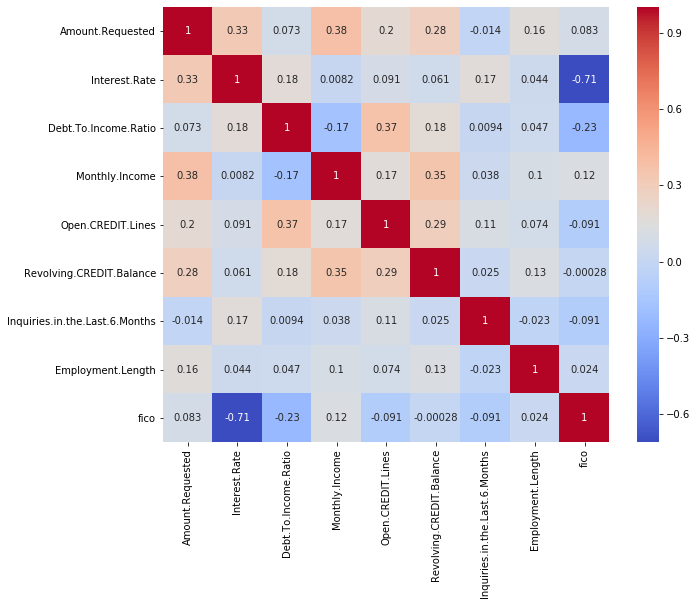

In [67]:
ax, fig = plt.subplots(figsize=(10,8))
sns.heatmap(numerical.corr(), annot=True, cmap='coolwarm')
plt.show()

### 2.3. Outliers

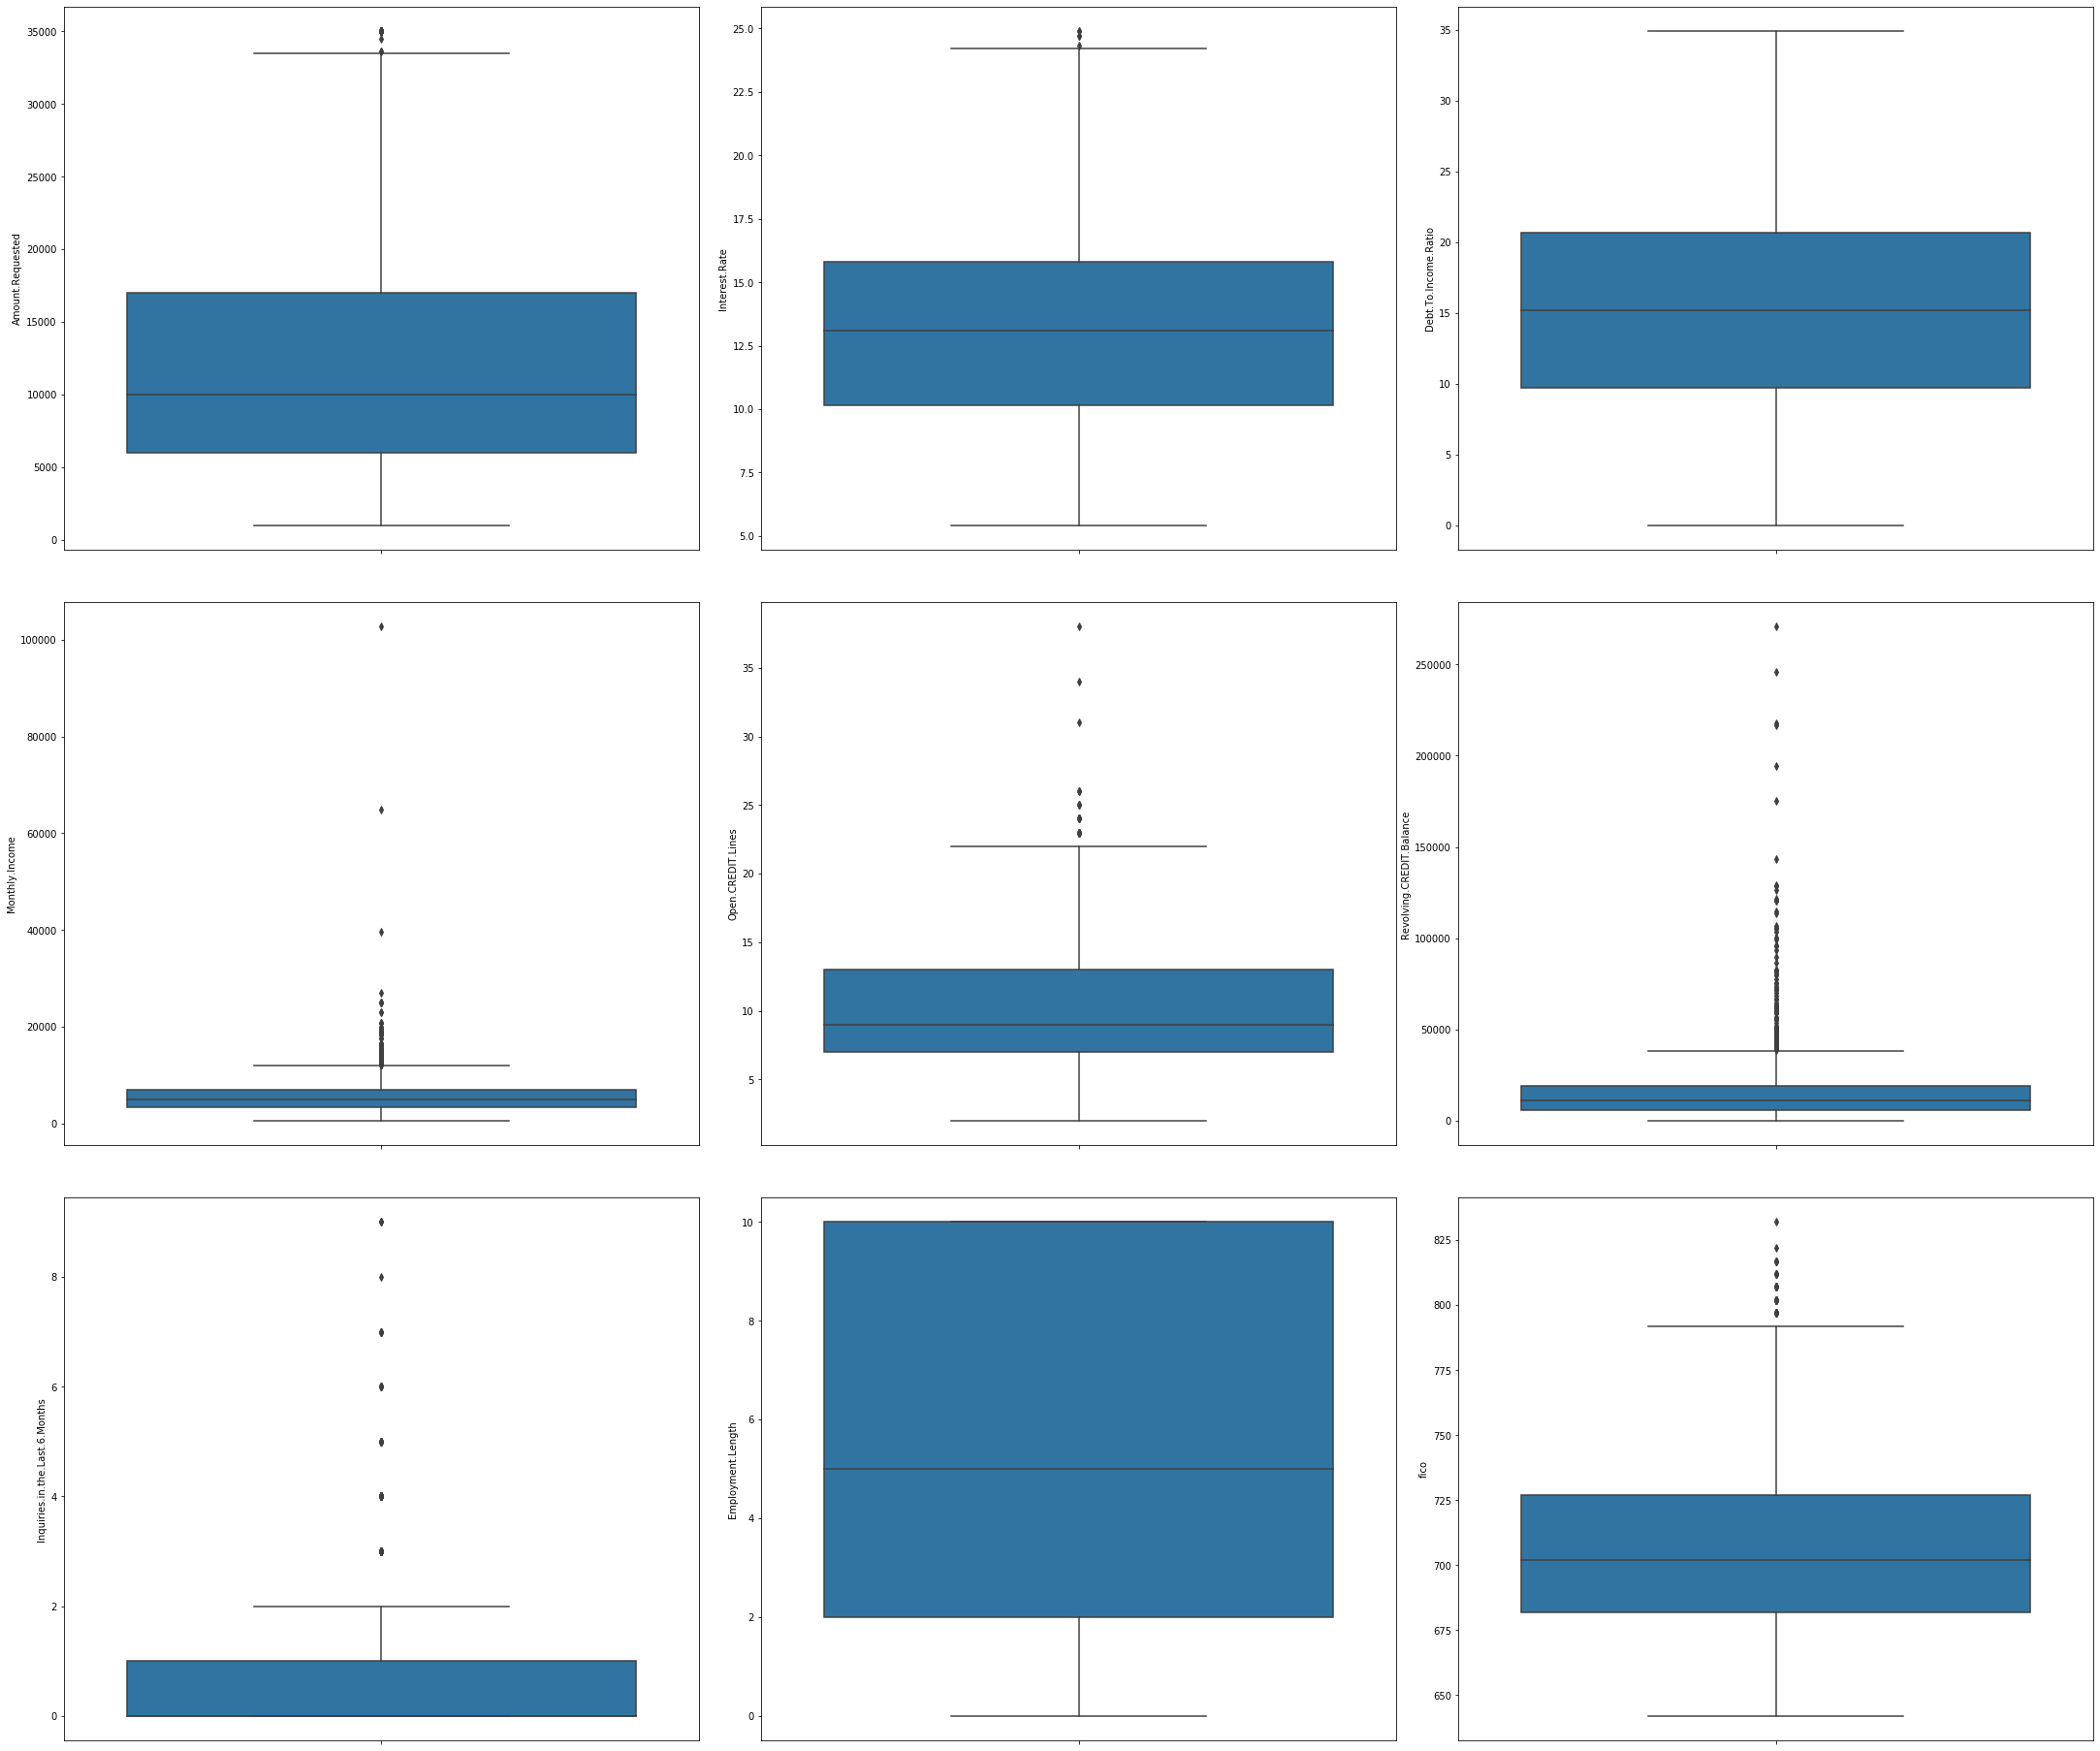

In [68]:
from scipy import stats

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(30, 25))
index = 0
axs = axs.flatten()
for k,v in numerical.items():
    sns.boxplot(y=k, data=numerical, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [69]:
for k, v in numerical.items(): #k=column_name, v=values
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(numerical)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column Amount.Requested outliers = 2.32%
Column Interest.Rate outliers = 0.23%
Column Debt.To.Income.Ratio outliers = 0.00%
Column Monthly.Income outliers = 4.95%
Column Open.CREDIT.Lines outliers = 1.55%
Column Revolving.CREDIT.Balance outliers = 5.64%
Column Inquiries.in.the.Last.6.Months outliers = 10.09%
Column Employment.Length outliers = 0.00%
Column fico outliers = 2.23%


### 2.4. Missing values

In [72]:
df_train.isnull().sum()

Amount.Requested                    5
Interest.Rate                       0
Debt.To.Income.Ratio                1
Monthly.Income                      3
Open.CREDIT.Lines                   7
Revolving.CREDIT.Balance            5
Inquiries.in.the.Last.6.Months      3
Employment.Length                  70
fico                                0
Loan.Length.36 months               0
Loan.Length.60 months               0
Loan.Purpose.debt_consolidation     0
Loan.Purpose.credit_card            0
Loan.Purpose.other                  0
Loan.Purpose.home_improvement       0
Loan.Purpose.major_purchase         0
Loan.Purpose.small_business         0
Loan.Purpose.car                    0
Loan.Purpose.wedding                0
Loan.Purpose.medical                0
Loan.Purpose.moving                 0
State.CA                            0
State.NY                            0
State.FL                            0
State.TX                            0
State.PA                            0
State.IL    

In [73]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [74]:
# imputer.fit(df_train) #learn the positions which has to be imputed
# imputer.transform(df_train) #actually perform the imputer operation 
# imputer.fit(df_train) + imputer.transform(df_train) = imputer.fit_transform(df_train)

In [75]:
#return type for imputer is always array. We have to convert that back to dataframe
# How to convert array to dataframe:
# new_df = pd.Dataframe(array)

In [76]:
df_train = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)

In [77]:
df_train.isnull().sum()

Amount.Requested                   0
Interest.Rate                      0
Debt.To.Income.Ratio               0
Monthly.Income                     0
Open.CREDIT.Lines                  0
Revolving.CREDIT.Balance           0
Inquiries.in.the.Last.6.Months     0
Employment.Length                  0
fico                               0
Loan.Length.36 months              0
Loan.Length.60 months              0
Loan.Purpose.debt_consolidation    0
Loan.Purpose.credit_card           0
Loan.Purpose.other                 0
Loan.Purpose.home_improvement      0
Loan.Purpose.major_purchase        0
Loan.Purpose.small_business        0
Loan.Purpose.car                   0
Loan.Purpose.wedding               0
Loan.Purpose.medical               0
Loan.Purpose.moving                0
State.CA                           0
State.NY                           0
State.FL                           0
State.TX                           0
State.PA                           0
State.IL                           0
S

## Step 3: Defining Training and Test Set

In [79]:
#dataframe.values --> will return array
X_train, y_train = df_train.loc[:,df_train.columns!="Interest.Rate"].values, df_train["Interest.Rate"].values
X_train.shape, y_train.shape

((2200, 49), (2200,))

## Step 4: Data Scaling

In [80]:
from sklearn.preprocessing import StandardScaler #mean=0, std_deviation=1.0
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)

## Step 5: Test set pipeline

In [81]:
def preprocessing(dataframe, to_store, std):
    
    #Operation1
    dataframe = dataframe.drop(['ID','Amount.Funded.By.Investors'],axis=1)
    
    #Operation2
    for col in ['Amount.Requested', 'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
        dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce')
    
    #Operation3
    for col in ['Debt.To.Income.Ratio']:
        dataframe[col] = dataframe[col].str.replace("%","") 
    
    for col in ['Debt.To.Income.Ratio']:
        dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce') 
    
    #Operation4
    k=dataframe['FICO.Range'].str.split("-",expand=True).astype(float)
    dataframe['fico']=0.5*(k[0]+k[1])
    del dataframe['FICO.Range']
    
    #Operation5
    dataframe['Employment.Length']=dataframe['Employment.Length'].str.replace('years',"")
    dataframe['Employment.Length']=dataframe['Employment.Length'].str.replace('year',"")
    
    dataframe['Employment.Length']=np.where(dataframe['Employment.Length'].str[:2]=="10",10,
                                       dataframe['Employment.Length'])

    dataframe['Employment.Length']=np.where(dataframe['Employment.Length'].str[0]=="<",0,
                                       dataframe['Employment.Length'])
    
    dataframe['Employment.Length']=pd.to_numeric(dataframe['Employment.Length'],errors='coerce')
    
    #Operation6
    for column, categories in to_store:
        for category in categories:
            name=column+'.'+category
            dataframe[name]=(dataframe[column]==category).astype(int)
        del dataframe[column]
    
    #Missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    dataframe = pd.DataFrame(imputer.fit_transform(dataframe), columns=dataframe.columns)
    
    #data scaling
    X_test = dataframe.values
    X_test = std.transform(X_test) #standard scaling
    
    return X_test

In [82]:
X_test = preprocessing(df_test, to_store, std)
X_test.shape

(300, 49)

## Step 6: Modelling

### Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
test_pred = lm.predict(X_test)

We can write these to a csv file for submission like this :

In [87]:
pd.DataFrame(test_pred).to_csv("mysubmission.csv",index=False)

### Ridge  Regression

In [88]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [89]:
model=Ridge()

In [90]:
alpha=np.linspace(1,100,100) #defiing range for values for lambda
params={'alpha':alpha}

In [91]:
#GridSearchCV by default choses best model based on max score obtained. 
grid_search = GridSearchCV(model, param_grid=params, cv=10, scoring='neg_mean_absolute_error')

In [92]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,...
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.]

In [93]:
grid_search.best_estimator_

Ridge(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [94]:
grid_search.cv_results_

{'mean_fit_time': array([0.00302329, 0.00262604, 0.00217073, 0.00192585, 0.0020261 ,
        0.00162032, 0.00161676, 0.00166183, 0.00151227, 0.00136616,
        0.00126662, 0.0012922 , 0.00131195, 0.00131092, 0.00128143,
        0.00133278, 0.00166733, 0.00168726, 0.00166459, 0.00183842,
        0.00178113, 0.00150111, 0.0015677 , 0.00152152, 0.00148861,
        0.00126581, 0.00127673, 0.00129244, 0.00133677, 0.00135455,
        0.00139272, 0.00137219, 0.00136702, 0.00132694, 0.00125768,
        0.00125709, 0.00130503, 0.0012434 , 0.00135531, 0.00145841,
        0.00134993, 0.0012758 , 0.00144897, 0.0016366 , 0.00236628,
        0.00164461, 0.00181177, 0.00190086, 0.00139279, 0.0018748 ,
        0.00189595, 0.0014751 , 0.00163615, 0.00152044, 0.00137773,
        0.00133581, 0.00127506, 0.00124669, 0.00135486, 0.00126121,
        0.00136051, 0.00133059, 0.00139351, 0.00130601, 0.00127084,
        0.00157907, 0.00147936, 0.00228667, 0.00168402, 0.00158358,
        0.00150292, 0.00133166,

 if you want you can now fit a ridge regression model with obtained value of alpha , although there is no need, grid search automatically fits the best estimator on the entire data, you can directly use this to make predictions on test_data. But if you want to look at coefficients , its much more convenient to fit the model with direct function

Using the report function given below you can see the cv performance of top few models as well, that will the tentative performance

In [96]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [97]:
report(grid_search.cv_results_,100)

Model with rank: 1
Mean validation score: -1.618 (std: 0.119)
Parameters: {'alpha': 3.0}

Model with rank: 2
Mean validation score: -1.618 (std: 0.118)
Parameters: {'alpha': 4.0}

Model with rank: 3
Mean validation score: -1.618 (std: 0.119)
Parameters: {'alpha': 2.0}

Model with rank: 4
Mean validation score: -1.618 (std: 0.118)
Parameters: {'alpha': 5.0}

Model with rank: 5
Mean validation score: -1.618 (std: 0.119)
Parameters: {'alpha': 1.0}

Model with rank: 6
Mean validation score: -1.618 (std: 0.118)
Parameters: {'alpha': 6.0}

Model with rank: 7
Mean validation score: -1.618 (std: 0.118)
Parameters: {'alpha': 7.0}

Model with rank: 8
Mean validation score: -1.618 (std: 0.118)
Parameters: {'alpha': 8.0}

Model with rank: 9
Mean validation score: -1.618 (std: 0.117)
Parameters: {'alpha': 9.0}

Model with rank: 10
Mean validation score: -1.618 (std: 0.117)
Parameters: {'alpha': 10.0}

Model with rank: 11
Mean validation score: -1.619 (std: 0.117)
Parameters: {'alpha': 11.0}

Model 

In [95]:
test_pred=grid_search.predict(X_test)

In [ ]:
pd.DataFrame(test_pred).to_csv("mysubmission.csv",index=False)